In [1]:
from IPython.display import clear_output
!pip install cleverhans
clear_output()

In [2]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Hyperparameters
batch_size = 128

# CIFAR-10 dataset with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [4]:
# Load CIFAR-10
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split training dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 35284298.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


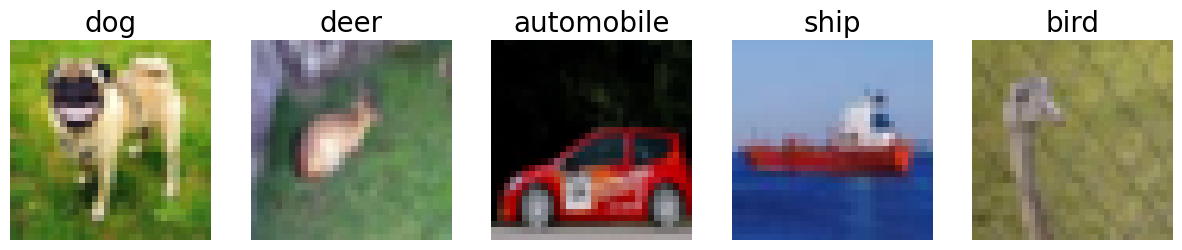

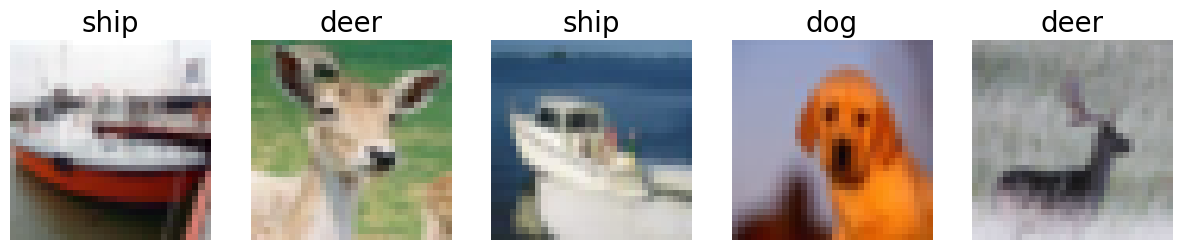

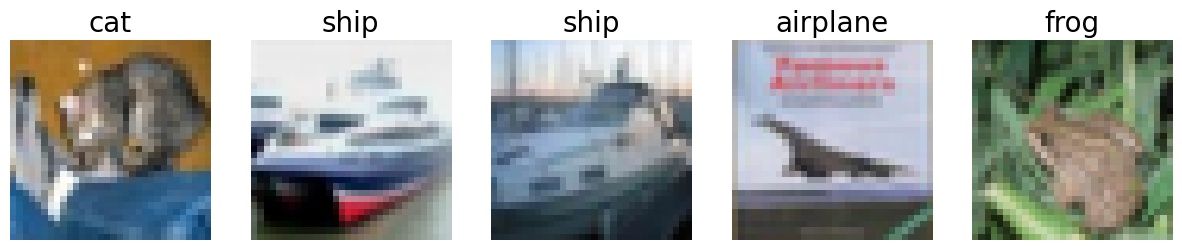

In [5]:
def show_samples(data_loader):
    import numpy as np
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:5]
    labels = labels[:5]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = (images[i].permute(1, 2, 0).numpy() * 0.5) + 0.5  # Denormalize
        ax.imshow(img)
        ax.set_title(f"{CLASSES[labels[i].item()]}", fontsize=20)
        ax.axis("off")
    plt.show()

show_samples(train_loader)
show_samples(val_loader)
show_samples(test_loader)

In [6]:
target_model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True
).to(device)
target_model.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 32.8MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [7]:
# Evaluate accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 81.13%


In [8]:
def attack_success_rate(model, adv_examples):
    total = 0
    success = 0

    # Iterate over batches of original and adversarial examples
    for orig_images, adv_images in adv_examples:
        with torch.no_grad():
            orig_preds = model(orig_images).argmax(dim=1)
            adv_preds = model(adv_images).argmax(dim=1)

            # Count successful attacks where predictions differ
            success += (orig_preds != adv_preds).sum().item()
            total += orig_images.size(0)

    return success / total

In [9]:
# Generate adversarial images using FGSM
epsilon = 0.01

adv_examples = []
true_labels = []
pred_labels_orig = []
pred_labels_adv = []

target_model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    adv_images = fast_gradient_method(target_model, images, epsilon, norm=np.inf)
    adv_examples.append((images, adv_images))
    true_labels.extend(labels.cpu().numpy())
    
    with torch.no_grad():
        orig_preds = target_model(images).argmax(dim=1)
        adv_preds = target_model(adv_images).argmax(dim=1)
        pred_labels_orig.extend(orig_preds.cpu().numpy())
        pred_labels_adv.extend(adv_preds.cpu().numpy())

success_rate = attack_success_rate(target_model, adv_examples)
print(f"Attack Success Rate: {success_rate * 100:.2f}%")

Attack Success Rate: 73.80%


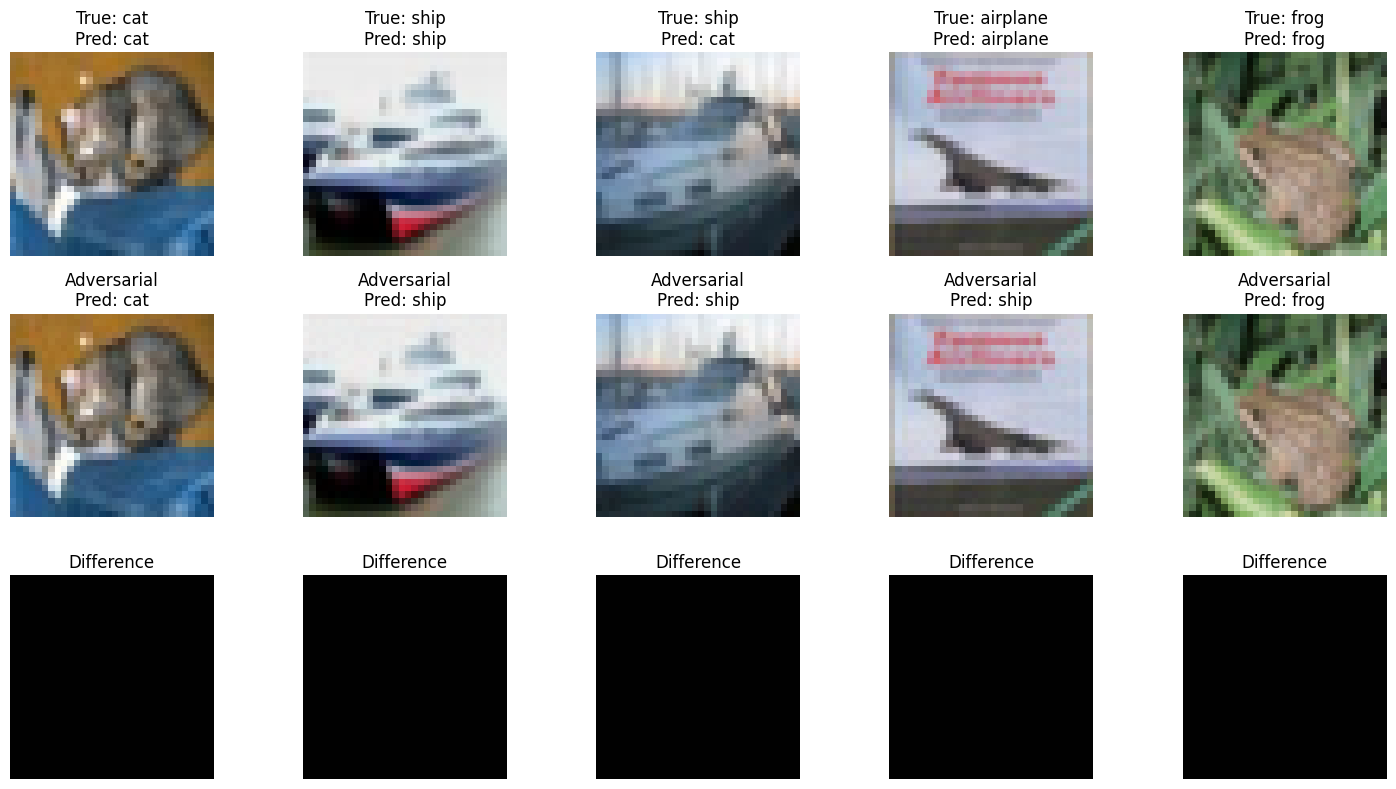

In [10]:
def show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv):
    orig_images, adv_images = adv_examples[0]  # Example batch
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        orig = (orig_images[i].cpu().permute(1, 2, 0).detach().numpy() * 0.5) + 0.5
        adv = (adv_images[i].cpu().permute(1, 2, 0).detach().numpy() * 0.5) + 0.5
        diff = np.abs(adv - orig)

        true_label = CLASSES[true_labels[i]]
        orig_pred_label = CLASSES[pred_labels_orig[i]]
        adv_pred_label = CLASSES[pred_labels_adv[i]]

        axes[0, i].imshow(orig)
        axes[0, i].set_title(f"True: {true_label}\nPred: {orig_pred_label}")
        axes[0, i].axis("off")
        axes[1, i].imshow(adv)
        axes[1, i].set_title(f"Adversarial\nPred: {adv_pred_label}")
        axes[1, i].axis("off")
        axes[2, i].imshow(diff)
        axes[2, i].set_title("Difference")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv)


In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=8),  # 8x8 -> 1x1
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x).view(-1)

In [12]:
# Loss functions
adv_loss_fn = nn.CrossEntropyLoss()  # Fooling loss
hinge_loss_fn = nn.ReLU()  # Perturbation penalty (soft hinge)
# hinge_loss_fn = lambda perturb: torch.mean(torch.clamp(torch.norm(perturb.view(perturb.size(0), -1), dim=1) - c, min=0))

# def gan_loss_fn(discriminator, real_images, fake_images):
#     real_loss = torch.mean((discriminator(real_images) - 1) ** 2)
#     fake_loss = torch.mean(discriminator(fake_images) ** 2)
#     return real_loss + fake_loss
gan_loss_fn = nn.BCEWithLogitsLoss()

In [13]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Hyperparameters
epochs = 50 
lr = 0.001
# alpha, beta = 1.0, 0.1  # Weights for GAN and hinge loss
alpha = 1.0  # Weight for GAN loss
beta = 10.0  # Weight for hinge loss
# c = 0.1  # Perturbation bound
c = 8/255 # Perturbation bound (c) = 8/255 for CIFAR-10

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=10, gamma=0.5)
d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=10, gamma=0.5)


In [14]:
# Training loop

g_losses, d_losses = [], []
g_accuracies = []
best_g_loss = float('inf') 
best_d_loss = float('inf')
epochs_no_improve = 0 
patience = 15

for epoch in range(epochs):
    g_loss_epoch, d_loss_epoch = 0.0, 0.0
    correct_adv = 0  # For accuracy of the generator fooling the target model
    total_samples = 0
    
    tepoch = tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}", ncols=100, leave=False)

    generator.train()
    discriminator.train()
    for batch_idx, (images, labels) in enumerate(tepoch):
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        perturbations = generator(images)
        adv_images = torch.clamp(images + perturbations, -1, 1)

        # Discriminator step
        d_optimizer.zero_grad()
        real_output = discriminator(images)  # Discriminator output for real images
        fake_output = discriminator(adv_images.detach())  # Discriminator output for adversarial images
        real_targets = torch.ones(real_output.size(), device=device)  # Target for real images
        fake_targets = torch.zeros(fake_output.size(), device=device)  # Target for fake images

        real_loss = gan_loss_fn(real_output, real_targets)
        fake_loss = gan_loss_fn(fake_output, fake_targets)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Generator step
        g_optimizer.zero_grad()
        adv_output = target_model(adv_images)
        fooling_loss = adv_loss_fn(adv_output, labels)
        perturb_penalty = hinge_loss_fn(torch.norm(perturbations.view(perturbations.size(0), -1), dim=1) - c).mean()

        fake_output = discriminator(adv_images)  # Recompute discriminator output for adversarial images
        gan_loss = gan_loss_fn(fake_output, real_targets)  # Generator tries to fool the discriminator

        g_loss = fooling_loss + alpha * gan_loss + beta * perturb_penalty
        g_loss.backward()
        g_optimizer.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

        # Calculate accuracy for adversarial examples
        _, predicted = adv_output.max(1)
        correct_adv += (predicted != labels).sum().item()  # Target model fooled
        total_samples += labels.size(0)
        
        tepoch.set_postfix({ 
            'Batch': batch_idx + 1, 
            'G_Loss': g_loss.item(), 
            'D_Loss': d_loss.item() 
        })

    g_losses.append(g_loss_epoch / len(train_loader))
    d_losses.append(d_loss_epoch / len(train_loader))
    g_accuracies.append(correct_adv / total_samples)
    
    print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {g_losses[-1]:.4f}, Discriminator Loss: {d_losses[-1]:.4f}, Fooling Accuracy: {g_accuracies[-1]:.4f}")

    generator.eval()
    discriminator.eval()
    
    g_scheduler.step()
    d_scheduler.step()
    
    if g_losses[-1] < best_g_loss or d_losses[-1] < best_d_loss:
        best_g_loss = min(g_losses[-1], best_g_loss)
        best_d_loss = min(d_losses[-1], best_d_loss)
        epochs_no_improve = 0
    else:
        print(f"Epochs without improvement: {epochs_no_improve + 1}/{patience}")
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

Epoch [1/50], Generator Loss: 29.1004, Discriminator Loss: 1.3460, Fooling Accuracy: 0.3203


Epoch [2/50], Generator Loss: 7.8659, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1734


Epoch [3/50], Generator Loss: 5.8371, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1590


Epoch [4/50], Generator Loss: 5.5613, Discriminator Loss: 1.3858, Fooling Accuracy: 0.1619


Epoch [5/50], Generator Loss: 5.7564, Discriminator Loss: 1.3848, Fooling Accuracy: 0.1684
Epochs without improvement: 1/15


Epoch [6/50], Generator Loss: 4.6804, Discriminator Loss: 1.3844, Fooling Accuracy: 0.1598


Epoch [7/50], Generator Loss: 4.0552, Discriminator Loss: 1.3840, Fooling Accuracy: 0.1515


Epoch [8/50], Generator Loss: 3.7173, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1506


Epoch [9/50], Generator Loss: 3.7935, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1517
Epochs without improvement: 1/15


Epoch [10/50], Generator Loss: 3.4701, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1507


Epoch [11/50], Generator Loss: 2.1346, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1408


Epoch [12/50], Generator Loss: 2.3097, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1416
Epochs without improvement: 1/15


Epoch [13/50], Generator Loss: 2.2659, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1409
Epochs without improvement: 2/15


Epoch [14/50], Generator Loss: 2.0537, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1407


Epoch [15/50], Generator Loss: 2.0826, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1413
Epochs without improvement: 1/15


Epoch [16/50], Generator Loss: 2.4592, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1419
Epochs without improvement: 2/15


Epoch [17/50], Generator Loss: 2.0741, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1413
Epochs without improvement: 3/15


Epoch [18/50], Generator Loss: 2.3059, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1459
Epochs without improvement: 4/15


Epoch [19/50], Generator Loss: 1.9960, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1413


Epoch [20/50], Generator Loss: 2.2332, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1402
Epochs without improvement: 1/15


Epoch [21/50], Generator Loss: 1.5765, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1383


Epoch [22/50], Generator Loss: 1.5612, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1381


Epoch [23/50], Generator Loss: 1.5289, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1379


Epoch [24/50], Generator Loss: 1.5827, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1386
Epochs without improvement: 1/15


Epoch [25/50], Generator Loss: 1.5836, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1384
Epochs without improvement: 2/15


Epoch [26/50], Generator Loss: 1.5981, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1384
Epochs without improvement: 3/15


Epoch [27/50], Generator Loss: 1.5497, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1384
Epochs without improvement: 4/15


Epoch [28/50], Generator Loss: 1.6063, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1381
Epochs without improvement: 5/15


Epoch [29/50], Generator Loss: 1.6689, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1387
Epochs without improvement: 6/15


Epoch [30/50], Generator Loss: 1.5846, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1382
Epochs without improvement: 7/15


Epoch [31/50], Generator Loss: 1.3749, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1374


Epoch [32/50], Generator Loss: 1.4704, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1374
Epochs without improvement: 1/15


Epoch [33/50], Generator Loss: 1.3873, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1375
Epochs without improvement: 2/15


Epoch [34/50], Generator Loss: 1.4254, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1375
Epochs without improvement: 3/15


Epoch [35/50], Generator Loss: 1.4018, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1375
Epochs without improvement: 4/15


Epoch [36/50], Generator Loss: 1.3765, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1372
Epochs without improvement: 5/15


Epoch [37/50], Generator Loss: 1.3689, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373


Epoch [38/50], Generator Loss: 1.3699, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1376
Epochs without improvement: 1/15


Epoch [39/50], Generator Loss: 1.3606, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1376


Epoch [40/50], Generator Loss: 1.3766, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1374
Epochs without improvement: 1/15


Epoch [41/50], Generator Loss: 1.2958, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373


Epoch [42/50], Generator Loss: 1.2898, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373


Epoch [43/50], Generator Loss: 1.2915, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1372
Epochs without improvement: 1/15


Epoch [44/50], Generator Loss: 1.2892, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373


Epoch [45/50], Generator Loss: 1.2973, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1372
Epochs without improvement: 1/15


Epoch [46/50], Generator Loss: 1.3051, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373
Epochs without improvement: 2/15


Epoch [47/50], Generator Loss: 1.2940, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373
Epochs without improvement: 3/15


Epoch [48/50], Generator Loss: 1.3473, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373
Epochs without improvement: 4/15


Epoch [49/50], Generator Loss: 1.2895, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1373
Epochs without improvement: 5/15


Epoch [50/50], Generator Loss: 1.2863, Discriminator Loss: 1.3863, Fooling Accuracy: 0.1371


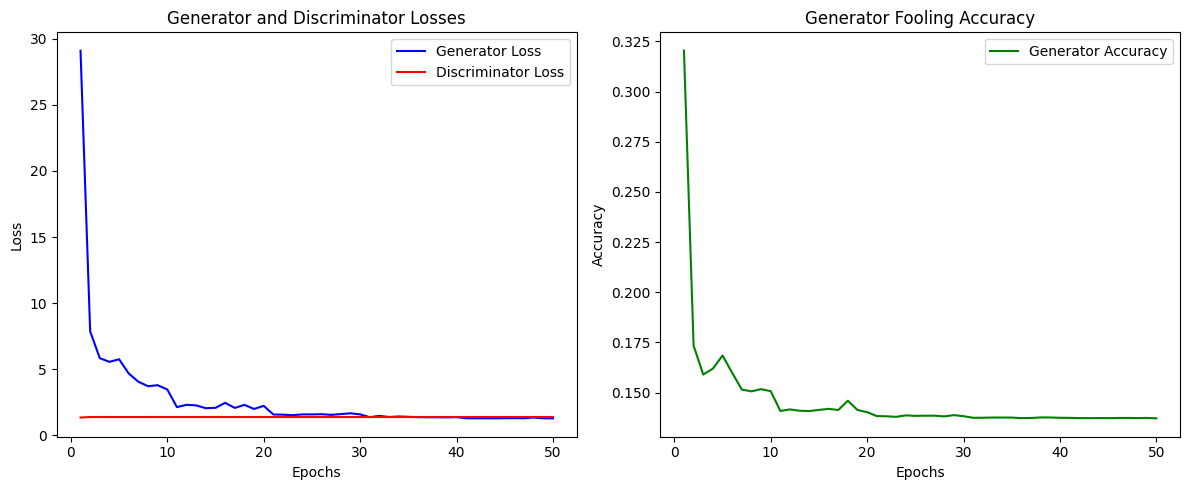

In [15]:
# Plot losses
plt.figure(figsize=(12, 5))

# Generator and Discriminator Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), g_losses, label='Generator Loss', color='blue')
plt.plot(range(1, epochs + 1), d_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()

# Generator Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), g_accuracies, label='Generator Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Generator Fooling Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def calculate_attack_success(target_model, test_loader, generator):
    overall_success = 0
    per_class_success = np.zeros(10)
    per_class_count = np.zeros(10)

    generator.eval()
    target_model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)

            # Get predictions on adversarial samples
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)

            # Check if target model was fooled
            fooled = (adv_preds != labels).cpu().numpy()
            overall_success += fooled.sum()

            # Update per-class metrics
            for label, is_fooled in zip(labels.cpu().numpy(), fooled):
                per_class_count[label] += 1
                per_class_success[label] += is_fooled

    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count

    return overall_rate, per_class_rate

In [17]:
overall_rate, per_class_rate = calculate_attack_success(target_model, test_loader, generator)

print(f"Overall Attack Success Rate: {overall_rate * 100:.2f}%")
for i, class_name in enumerate(CLASSES):
    print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")

Overall Attack Success Rate: 18.87%
Class airplane: 15.90%
Class automobile: 18.00%
Class bird: 25.90%
Class cat: 17.50%
Class deer: 16.50%
Class dog: 26.90%
Class frog: 19.60%
Class horse: 23.30%
Class ship: 7.60%
Class truck: 17.50%


In [18]:
def visualize_adversarial_samples(generator, test_loader):
    generator.eval()

    images, labels = next(iter(test_loader))
    images, labels = images[:5].to(device), labels[:5].to(device)
    with torch.no_grad():
        perturbations = generator(images)
        adv_images = torch.clamp(images + perturbations, -1, 1)

    images = images.cpu()
    adv_images = adv_images.cpu()
    perturbations = perturbations.cpu()

    # Plot original, adversarial, and perturbations
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        # Original image
        axes[0, i].imshow(((images[i].permute(1, 2, 0) * 0.5) + 0.5).numpy())
        axes[0, i].set_title(f"Original: {CLASSES[labels[i]]}")
        axes[0, i].axis("off")

        # Adversarial image
        axes[1, i].imshow(((adv_images[i].permute(1, 2, 0) * 0.5) + 0.5).numpy())
        axes[1, i].set_title("Adversarial")
        axes[1, i].axis("off")

        # Perturbation
        axes[2, i].imshow((perturbations[i].permute(1, 2, 0).numpy() * 0.5 + 0.5), cmap="seismic")
        axes[2, i].set_title("Perturbation")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

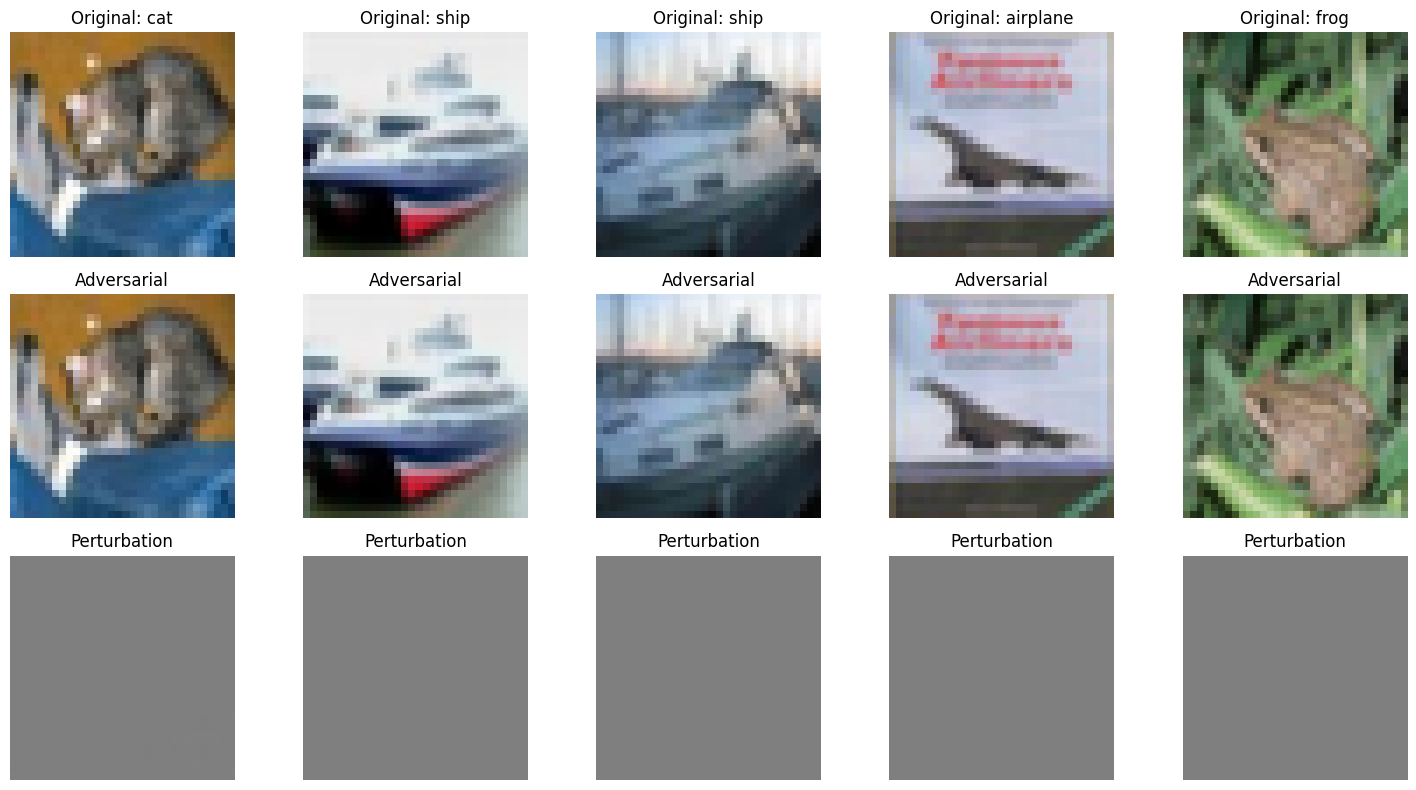

In [19]:
visualize_adversarial_samples(generator, test_loader)

In [20]:
def plot_confidence_histograms(target_model, test_loader, generator):
    normal_confidences = []
    adversarial_confidences = []

    generator.eval()
    target_model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)

            # Get softmax confidence for normal and adversarial images
            normal_outputs = torch.softmax(target_model(images), dim=1)
            adv_outputs = torch.softmax(target_model(adv_images), dim=1)

            normal_confidences.extend(normal_outputs.max(1)[0].cpu().numpy())
            adversarial_confidences.extend(adv_outputs.max(1)[0].cpu().numpy())

    # Plot histograms
    plt.figure(figsize=(10, 5))
    plt.hist(adversarial_confidences, bins=20, alpha=0.7, label="Adversarial Samples", color="red")
    plt.hist(normal_confidences, bins=20, alpha=0.7, label="Normal Samples", color="blue")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.title("Confidence Histogram: Normal vs Adversarial")
    plt.legend()
    plt.show()

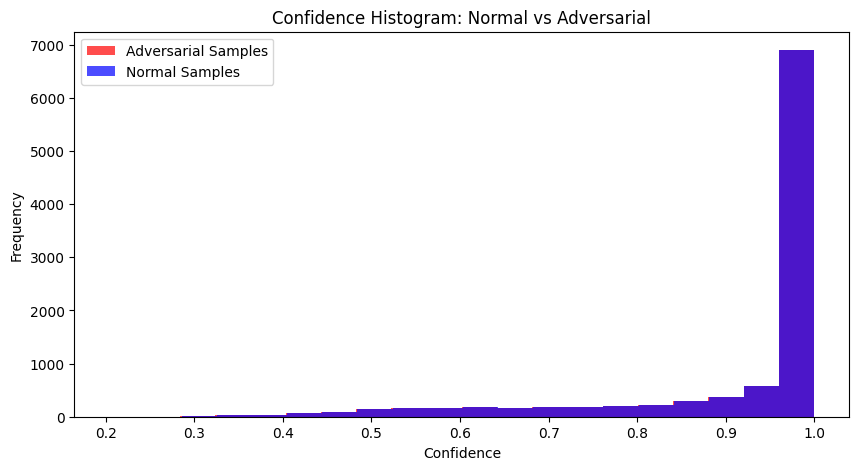

In [21]:
plot_confidence_histograms(target_model, test_loader, generator)

In [22]:
# Update fooling loss for targeted attack
target_class = 0  # Example: Force adversarial images to be classified as "airplane" (class 0)
fooling_loss = adv_loss_fn(adv_output, torch.full_like(labels, target_class))

In [23]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Hyperparameters
epochs = 50 
lr = 0.001
# alpha, beta = 1.0, 0.1  # Weights for GAN and hinge loss
alpha = 1.0  # Weight for GAN loss
beta = 10.0  # Weight for hinge loss
c = 0.1  # Perturbation bound 
# c = 8 / 255
# c = 8/255 # 0.01  # Perturbation bound (c) = 8/255 for CIFAR-10

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

g_scheduler = ReduceLROnPlateau(g_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
d_scheduler = ReduceLROnPlateau(d_optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [24]:
g_losses, d_losses = [], []
g_accuracies = []
best_g_loss = float('inf') 
epochs_no_improve = 0 
patience = 15

# Training loop
for epoch in range(epochs):
    g_loss_epoch, d_loss_epoch = 0.0, 0.0
    correct_adv = 0  # For accuracy of the generator fooling the target model
    total_samples = 0

    tepoch = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    generator.train()
    discriminator.train()
    for batch_idx, (images, labels) in enumerate(tepoch):
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        perturbations = generator(images)
        adv_images = torch.clamp(images + perturbations, -1, 1)

        # Discriminator step
        d_optimizer.zero_grad()
        real_loss = torch.mean((discriminator(images) - 1) ** 2)
        fake_loss = torch.mean(discriminator(adv_images.detach()) ** 2)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Generator step
        g_optimizer.zero_grad()
        adv_output = target_model(adv_images)
        # Targeted fooling loss
        fooling_loss = adv_loss_fn(adv_output, torch.full_like(labels, target_class))
        perturb_penalty = hinge_loss_fn(torch.norm(perturbations.view(perturbations.size(0), -1), dim=1) - c).mean()
        gan_loss = torch.mean((discriminator(adv_images) - 1) ** 2)  # GAN loss for generator

        g_loss = fooling_loss + alpha * gan_loss + beta * perturb_penalty
        g_loss.backward()
        g_optimizer.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

        # Calculate targeted attack success
        _, predicted = adv_output.max(1)
        correct_adv += (predicted == target_class).sum().item()  # Success if classified as target class
        total_samples += labels.size(0)

        tepoch.set_postfix({ 
            'Batch': batch_idx + 1, 
            'G_Loss': g_loss.item(), 
            'D_Loss': d_loss.item() 
        })

    # Record epoch losses and targeted attack accuracy
    g_losses.append(g_loss_epoch / len(train_loader))
    d_losses.append(d_loss_epoch / len(train_loader))
    g_accuracies.append(correct_adv / total_samples)

    print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {g_losses[-1]:.4f}, Discriminator Loss: {d_losses[-1]:.4f}, Fooling Accuracy (Target {target_class}): {g_accuracies[-1]:.4f}")

    generator.eval()
    discriminator.eval()
    
    g_scheduler.step(g_losses[-1])  # Use generator loss to adjust its learning rate
    d_scheduler.step(d_losses[-1])  # Use discriminator loss to adjust its learning rate
    
    if g_losses[-1] < best_g_loss or d_losses[-1] < best_d_loss:
        best_g_loss = min(g_losses[-1], best_g_loss)
        best_d_loss = min(d_losses[-1], best_d_loss)
        epochs_no_improve = 0
    else:
        print(f"Epochs without improvement: {epochs_no_improve + 1}/{patience}")
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

Epoch [1/50], Generator Loss: 25.0280, Discriminator Loss: 0.4720, Fooling Accuracy (Target 0): 0.0793


Epoch [2/50], Generator Loss: 14.5226, Discriminator Loss: 0.4889, Fooling Accuracy (Target 0): 0.0908


Epoch [3/50], Generator Loss: 12.5065, Discriminator Loss: 0.4825, Fooling Accuracy (Target 0): 0.0909


Epoch [4/50], Generator Loss: 13.7028, Discriminator Loss: 0.1405, Fooling Accuracy (Target 0): 0.0880


Epoch [5/50], Generator Loss: 14.5958, Discriminator Loss: 0.0522, Fooling Accuracy (Target 0): 0.0885


Epoch [6/50], Generator Loss: 13.9750, Discriminator Loss: 0.0429, Fooling Accuracy (Target 0): 0.0910


Epoch [7/50], Generator Loss: 13.6752, Discriminator Loss: 0.0540, Fooling Accuracy (Target 0): 0.0916
Epochs without improvement: 1/15


Epoch [8/50], Generator Loss: 13.3638, Discriminator Loss: 0.0378, Fooling Accuracy (Target 0): 0.0933


Epoch [9/50], Generator Loss: 12.7684, Discriminator Loss: 0.0569, Fooling Accuracy (Target 0): 0.0941
Epochs without improvement: 1/15


Epoch [10/50], Generator Loss: 12.1513, Discriminator Loss: 0.0736, Fooling Accuracy (Target 0): 0.0950


Epoch [11/50], Generator Loss: 12.1725, Discriminator Loss: 0.0907, Fooling Accuracy (Target 0): 0.0945
Epochs without improvement: 1/15


Epoch [12/50], Generator Loss: 12.1655, Discriminator Loss: 0.0391, Fooling Accuracy (Target 0): 0.0946
Epochs without improvement: 2/15


Epoch [13/50], Generator Loss: 12.0746, Discriminator Loss: 0.0896, Fooling Accuracy (Target 0): 0.0949


Epoch [14/50], Generator Loss: 12.2579, Discriminator Loss: 0.0244, Fooling Accuracy (Target 0): 0.0946


Epoch [15/50], Generator Loss: 12.3606, Discriminator Loss: 0.0496, Fooling Accuracy (Target 0): 0.0946
Epochs without improvement: 1/15


Epoch [16/50], Generator Loss: 11.9477, Discriminator Loss: 0.0675, Fooling Accuracy (Target 0): 0.0952


Epoch [17/50], Generator Loss: 11.4790, Discriminator Loss: 0.2073, Fooling Accuracy (Target 0): 0.0951


Epoch [18/50], Generator Loss: 10.5470, Discriminator Loss: 0.4968, Fooling Accuracy (Target 0): 0.0961


Epoch [19/50], Generator Loss: 11.7207, Discriminator Loss: 0.1046, Fooling Accuracy (Target 0): 0.0950
Epochs without improvement: 1/15


Epoch [20/50], Generator Loss: 11.5312, Discriminator Loss: 0.0982, Fooling Accuracy (Target 0): 0.0951
Epochs without improvement: 2/15


Epoch [21/50], Generator Loss: 11.8461, Discriminator Loss: 0.0197, Fooling Accuracy (Target 0): 0.0945


Epoch [22/50], Generator Loss: 12.0097, Discriminator Loss: 0.0319, Fooling Accuracy (Target 0): 0.0950
Epochs without improvement: 1/15


Epoch [23/50], Generator Loss: 11.7454, Discriminator Loss: 0.0315, Fooling Accuracy (Target 0): 0.0951
Epochs without improvement: 2/15


Epoch [24/50], Generator Loss: 11.3769, Discriminator Loss: 0.0608, Fooling Accuracy (Target 0): 0.0957
Epochs without improvement: 3/15


Epoch [25/50], Generator Loss: 11.2359, Discriminator Loss: 0.0406, Fooling Accuracy (Target 0): 0.0964
Epochs without improvement: 4/15


Epoch [26/50], Generator Loss: 11.0966, Discriminator Loss: 0.1061, Fooling Accuracy (Target 0): 0.0964
Epochs without improvement: 5/15


Epoch [27/50], Generator Loss: 11.0039, Discriminator Loss: 0.1457, Fooling Accuracy (Target 0): 0.0965
Epochs without improvement: 6/15


Epoch [28/50], Generator Loss: 11.0705, Discriminator Loss: 0.0629, Fooling Accuracy (Target 0): 0.0966
Epochs without improvement: 7/15


Epoch [29/50], Generator Loss: 11.0560, Discriminator Loss: 0.0711, Fooling Accuracy (Target 0): 0.0968
Epochs without improvement: 8/15


Epoch [30/50], Generator Loss: 10.5728, Discriminator Loss: 0.3902, Fooling Accuracy (Target 0): 0.0971
Epochs without improvement: 9/15


Epoch [31/50], Generator Loss: 10.2252, Discriminator Loss: 0.5442, Fooling Accuracy (Target 0): 0.0969


Epoch [32/50], Generator Loss: 10.2804, Discriminator Loss: 0.5207, Fooling Accuracy (Target 0): 0.0968
Epochs without improvement: 1/15


Epoch [33/50], Generator Loss: 10.1787, Discriminator Loss: 0.5157, Fooling Accuracy (Target 0): 0.0970


Epoch [34/50], Generator Loss: 10.1782, Discriminator Loss: 0.5089, Fooling Accuracy (Target 0): 0.0972


Epoch [35/50], Generator Loss: 10.1743, Discriminator Loss: 0.5087, Fooling Accuracy (Target 0): 0.0972


Epoch [36/50], Generator Loss: 10.1635, Discriminator Loss: 0.5077, Fooling Accuracy (Target 0): 0.0972


Epoch [37/50], Generator Loss: 10.1556, Discriminator Loss: 0.5069, Fooling Accuracy (Target 0): 0.0974


Epoch [38/50], Generator Loss: 10.1558, Discriminator Loss: 0.5059, Fooling Accuracy (Target 0): 0.0973
Epochs without improvement: 1/15


Epoch [39/50], Generator Loss: 10.1409, Discriminator Loss: 0.5052, Fooling Accuracy (Target 0): 0.0974


Epoch [40/50], Generator Loss: 10.1495, Discriminator Loss: 0.5038, Fooling Accuracy (Target 0): 0.0973
Epochs without improvement: 1/15


Epoch [41/50], Generator Loss: 10.1359, Discriminator Loss: 0.5033, Fooling Accuracy (Target 0): 0.0977


Epoch [42/50], Generator Loss: 10.1543, Discriminator Loss: 0.5032, Fooling Accuracy (Target 0): 0.0973
Epochs without improvement: 1/15


Epoch [43/50], Generator Loss: 10.1720, Discriminator Loss: 0.5025, Fooling Accuracy (Target 0): 0.0974
Epochs without improvement: 2/15


Epoch [44/50], Generator Loss: 10.1413, Discriminator Loss: 0.5021, Fooling Accuracy (Target 0): 0.0974
Epochs without improvement: 3/15


Epoch [45/50], Generator Loss: 10.1244, Discriminator Loss: 0.5018, Fooling Accuracy (Target 0): 0.0977


Epoch [46/50], Generator Loss: 10.1121, Discriminator Loss: 0.5015, Fooling Accuracy (Target 0): 0.0976


Epoch [47/50], Generator Loss: 10.1227, Discriminator Loss: 0.5013, Fooling Accuracy (Target 0): 0.0979
Epochs without improvement: 1/15


Epoch [48/50], Generator Loss: 10.1562, Discriminator Loss: 0.5008, Fooling Accuracy (Target 0): 0.0976
Epochs without improvement: 2/15


Epoch [49/50], Generator Loss: 10.1075, Discriminator Loss: 0.5008, Fooling Accuracy (Target 0): 0.0977


Epoch [50/50], Generator Loss: 10.1137, Discriminator Loss: 0.5008, Fooling Accuracy (Target 0): 0.0977
Epochs without improvement: 1/15


In [25]:
def calculate_targeted_attack_success(target_model, test_loader, generator, target_class):
    overall_success = 0
    per_class_success = np.zeros(10)
    per_class_count = np.zeros(10)

    generator.eval()
    target_model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)

            # Get predictions on adversarial samples
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)

            # Check if target model was successfully targeted
            targeted = (adv_preds == target_class).cpu().numpy()
            overall_success += targeted.sum()

            # Update per-class metrics
            for label, is_targeted in zip(labels.cpu().numpy(), targeted):
                per_class_count[label] += 1
                per_class_success[label] += is_targeted

    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count

    return overall_rate, per_class_rate

In [26]:
overall_rate, per_class_rate = calculate_targeted_attack_success(target_model, test_loader, generator, target_class)

print(f"Overall Targeted Attack Success Rate: {overall_rate * 100:.2f}%")
for i, class_name in enumerate(CLASSES):
    print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")


Overall Targeted Attack Success Rate: 9.83%
Class airplane: 84.70%
Class automobile: 1.70%
Class bird: 3.00%
Class cat: 0.80%
Class deer: 0.50%
Class dog: 0.80%
Class frog: 0.70%
Class horse: 0.70%
Class ship: 2.80%
Class truck: 2.60%


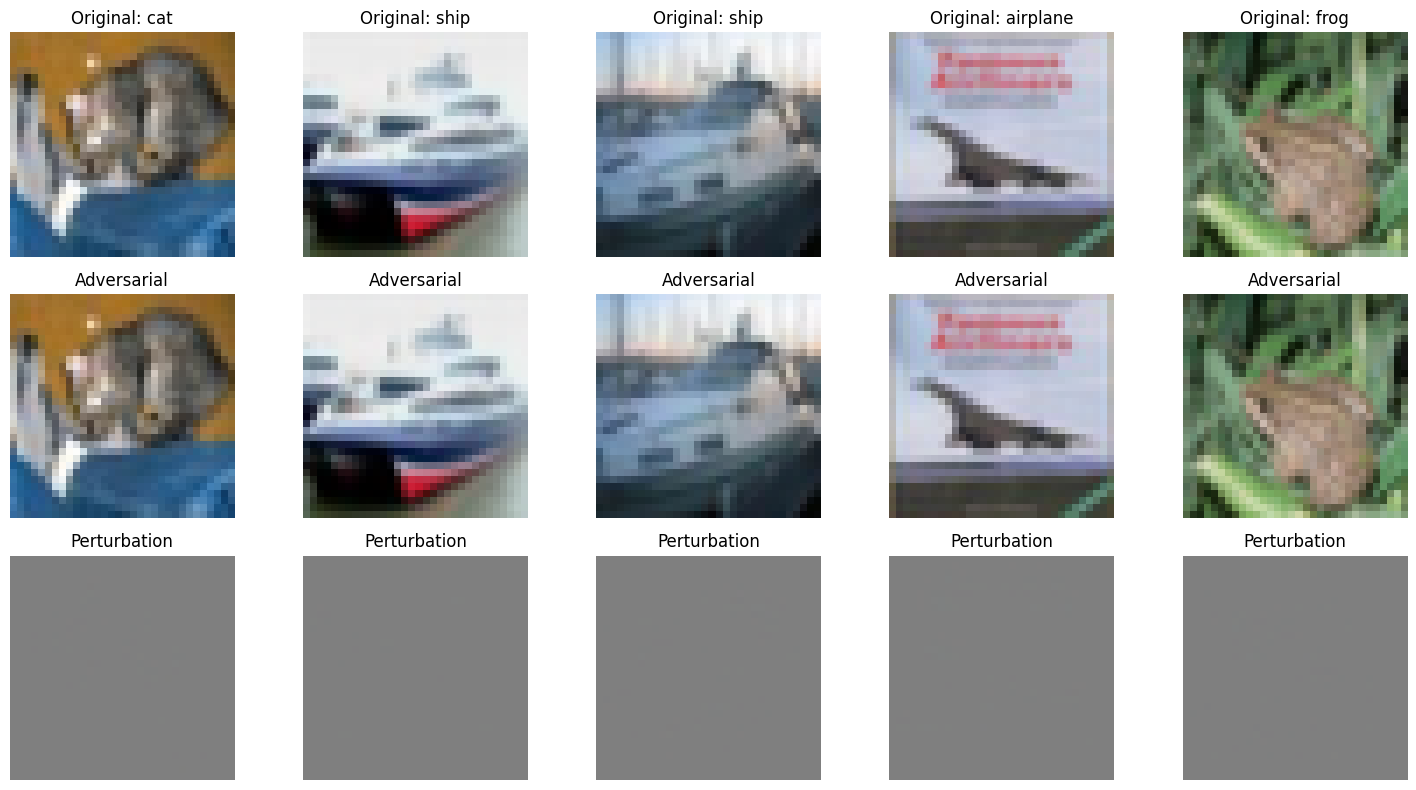

In [27]:
visualize_adversarial_samples(generator, test_loader)

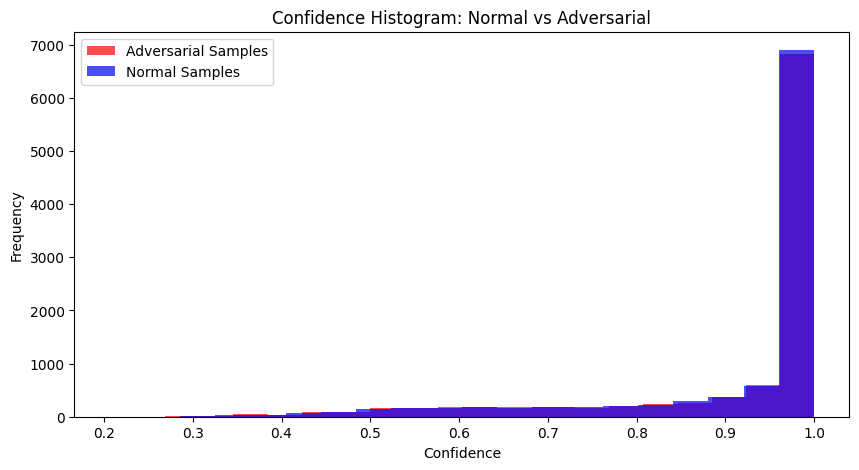

In [28]:
plot_confidence_histograms(target_model, test_loader, generator)

In [ ]:
# from IPython.display import clear_output
# !pip install cleverhans
# clear_output()

# import logging
# import numpy as np
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# from torch.utils.data import random_split, DataLoader
# from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

In [ ]:
# def show_samples(dataset, classes):
#     fig, axes = plt.subplots(1, 5, figsize=(15, 5))
#     for ax in axes:
#         idx = np.random.randint(0, len(dataset))
#         img, label = dataset[idx]
#         img = (img / 2 + 0.5).numpy()  # Unnormalize
#         img = np.transpose(img, (1, 2, 0))  # Convert to HWC format
#         ax.imshow(img)
#         ax.set_title(classes[label])
#         ax.axis('off')
#     plt.show()

In [ ]:
# def evaluate_model(model, data_loader):
#     total, correct = 0, 0
#     model.eval()

#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     return accuracy

# def generate_adversarial_examples(model, data_loader, epsilon):
#     original_images, adversarial_images, labels = [], [], []
#     successes, total = 0, 0
#     model.eval()

#     for images, targets in data_loader:
#         images, targets = images.to(device), targets.to(device)
#         original_images.append(images)
#         labels.append(targets)
#         images.requires_grad = True #//TODO::WTF::

#         adv_images = fast_gradient_method(model, images, eps=epsilon, norm=np.inf)
#         adversarial_images.append(adv_images)

#         with torch.no_grad():
#             outputs = model(adv_images)
#             _, predicted = torch.max(outputs, 1)
#             successes += (predicted != targets).sum().item()
#             total += targets.size(0)
            
#     success_rate = 100 * successes / total
#     return original_images, adversarial_images, labels, success_rate

# def visualize_adversarial_examples(orig_images, adv_images, labels, classes):
#     fig, axes = plt.subplots(3, 5, figsize=(15, 9))

#     for i in range(5):
#         idx = np.random.randint(0, len(orig_images))
#         orig_img = orig_images[idx][0]
#         adv_img = adv_images[idx][0]
#         label = labels[idx][0]

#         # Unnormalize images for visualization
#         orig_img = (orig_img / 2 + 0.5).cpu().detach().numpy()
#         adv_img = (adv_img / 2 + 0.5).cpu().detach().numpy()

#         diff_img = np.abs(adv_img - orig_img)

#         axes[0, i].imshow(np.transpose(orig_img, (1, 2, 0)))
#         axes[0, i].set_title(f"Original: {classes[label]}")
#         axes[0, i].axis('off')

#         axes[1, i].imshow(np.transpose(adv_img, (1, 2, 0)))
#         axes[1, i].set_title("Adversarial")
#         axes[1, i].axis('off')

#         axes[2, i].imshow(np.transpose(diff_img, (1, 2, 0)))
#         axes[2, i].set_title("Difference")
#         axes[2, i].axis('off')

#     plt.tight_layout()
#     plt.show()

In [ ]:
# def plot_training_metrics(g_losses, d_losses, accuracies):
#     epochs = range(1, len(g_losses) + 1)
    
#     plt.figure(figsize=(15, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, g_losses, label="Generator Loss", color='blue')
#     plt.plot(epochs, d_losses, label="Discriminator Loss", color='orange')
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.title("Generator and Discriminator Loss")
#     plt.legend()
#     plt.grid(True)
    
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, accuracies, label="Attack Success Rate", color='green')
#     plt.xlabel("Epochs")
#     plt.ylabel("Accuracy (%)")
#     plt.title("Attack Success Rate")
#     plt.legend()
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.show()

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [ ]:
# batch_size = 128
# epsilon = 0.01
# lr = 0.001
# epochs = 50

In [ ]:
# transform = transforms.Compose([
#     # transforms.Resize((128, 128)),  # Input size large enough for downsampling
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])

# train_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=True, download=True, transform=transform
# )
# test_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform
# )

In [ ]:
# classes = [
#     'airplane', 'automobile', 'bird', 'cat', 'deer',
#     'dog', 'frog', 'horse', 'ship', 'truck'
# ]

# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# show_samples(test_dataset, classes)

In [ ]:
# target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
# target_model = target_model.to(device)
# # target_model.eval()

In [ ]:
# accuracy = evaluate_model(target_model, test_loader)
# print(f"Accuracy of the pretrained ResNet-20 model on the test set: {accuracy:.2f}%")

In [ ]:
# original_images, adversarial_images, labels, success_rate = generate_adversarial_examples(
#     target_model, test_loader, epsilon
# )

# print(f"Attack success rate with epsilon {epsilon}: {success_rate:.2f}%")

In [ ]:
# visualize_adversarial_examples(original_images, adversarial_images, labels, classes)

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, input_channels=3):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.encoder = nn.ModuleList([
#             self.down_block(3, 64, normalize=False),
#             self.down_block(64, 128),
#             self.down_block(128, 256),
#             self.down_block(256, 512),
#         ])
#         self.bottleneck = self.down_block(512, 512, normalize=False)
#         self.decoder = nn.ModuleList([
#             self.up_block(512 + 512, 512, dropout=True),  # Bottleneck output + last encoder output
#             self.up_block(512 + 256, 256),                # Decoder output + encoder output
#             self.up_block(256 + 128, 128),                # Decoder output + encoder output
#             self.up_block(128 + 64, 64),                  # Decoder output + encoder output
#         ])
#         self.final = nn.Sequential(
#             nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Output 3 channels
#             nn.Tanh()
#         )
    
#     def down_block(self, in_channels, out_channels, normalize=True):
#         layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
#         if normalize:
#             layers.append(nn.BatchNorm2d(out_channels))
#         layers.append(nn.LeakyReLU(0.2))
#         return nn.Sequential(*layers)
    
#     def up_block(self, in_channels, out_channels, dropout=False):
#         layers = [
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU()
#         ]
#         if dropout:
#             layers.append(nn.Dropout(0.5))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         skip_connections = []
#         for down in self.encoder:
#             x = down(x)
#             skip_connections.append(x)

#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]
#         for idx, up in enumerate(self.decoder):
#             x = up(x)
#             if idx < len(skip_connections):
#                 x = torch.cat((x, skip_connections[idx]), dim=1)
#         return self.final(x)  # Returns perturbation G(x)


In [ ]:
# def adversarial_loss(output, target):
#     return nn.CrossEntropyLoss()(output, target)

# def gan_loss(discriminator_output, real):
#     target = torch.ones_like(discriminator_output) if real else torch.zeros_like(discriminator_output)
#     # return nn.BCELoss()(discriminator_output, target)
#     return torch.mean((discriminator_output - target) ** 2)
    
# # hinge_loss = torch.mean(torch.clamp(generator(images).norm(2, dim=(1, 2, 3)) - c, min=0))
# # For GANs training, we use the least squares objective proposed by LSGAN [Mao et al., 2017], as it has been shown to produce better results with more stable training.

In [ ]:
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

# d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-4)
# g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-4)

In [ ]:
# patience = 15
# recorded_g_loss = float('inf') 
# recorded_d_loss = float('inf')
# epochs_no_improve = 0 

# alpha, beta = 1.0, 0.1  # Weights for GAN and hinge loss
# c = 8/255 # 0.01  # Perturbation bound (c) = 8/255 for CIFAR-10
# g_losses, d_losses, accuracies = [], [], []

# for epoch in range(epochs):
#     g_loss_epoch, d_loss_epoch, correct = 0, 0, 0
#     total = 0

#     with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{epochs}", ncols=100) as tepoch:
#         for images, labels in tepoch:
#             images, labels = images.to(device), labels.to(device)

#             # Train Discriminator
#             d_optimizer.zero_grad()
#             real_output = discriminator(images)
#             fake_images = images + generator(images)
#             fake_output = discriminator(fake_images.detach())
        
#             d_real_loss = gan_loss(real_output, True)
#             d_fake_loss = gan_loss(fake_output, False)
#             d_loss = d_real_loss + d_fake_loss
#             d_loss.backward()
#             torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)  # Clip gradients
#             d_optimizer.step()
            
#             # Train Generator
#             g_optimizer.zero_grad()
#             adv_loss = adversarial_loss(target_model(fake_images), labels)
#             hinge_loss = torch.mean(torch.clamp(generator(images).norm(2, dim=(1, 2, 3)) - c, min=0))
#             gan_gen_loss = gan_loss(discriminator(fake_images), True)
        
#             g_loss = adv_loss + alpha * gan_gen_loss + beta * hinge_loss
#             g_loss.backward()
#             torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)  # Clip gradients
#             g_optimizer.step()

#             g_loss_epoch += g_loss.item()
#             d_loss_epoch += d_loss.item()
            
#             with torch.no_grad():
#                 total += labels.size(0)
#                 pred = target_model(fake_images).argmax(dim=1)
#                 correct += (pred != labels).sum().item()

#             tepoch.set_postfix(
#                 g_loss=f"{g_loss.item():.4f}",
#                 d_loss=f"{d_loss.item():.4f}",
#                 accuracy=f"{100 * correct / total:.2f}%"
#             )

#     g_loss_epoch /= len(train_loader)
#     d_loss_epoch /= len(train_loader)
#     accuracy = 100 * correct / total

#     g_losses.append(g_loss_epoch)
#     d_losses.append(d_loss_epoch)
#     accuracies.append(accuracy)

#     if g_loss_epoch < recorded_g_loss or d_loss_epoch < recorded_d_loss:
#         recorded_g_loss = min(g_loss_epoch, recorded_g_loss)
#         recorded_d_loss = min(d_loss_epoch, recorded_d_loss)
#         epochs_no_improve = 0
#     else:
#         print(f"Epochs without improvement: {epochs_no_improve + 1}/{patience}")
#         epochs_no_improve += 1
        
#     if epochs_no_improve >= patience:
#         print(f"Early stopping triggered after {epoch + 1} epochs.")
#         break

In [ ]:
# print(f"Recorded Generator Loss: {recorded_g_loss:.4f}")
# print(f"Recorded Discriminator Loss: {recorded_d_loss:.4f}")

In [ ]:
# plot_training_metrics(g_losses, d_losses, accuracies)